## Library

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
import time
import tempfile  # 추가
# import s3fs
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime, timedelta
from scipy.stats import shapiro, spearmanr, kruskal
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

## Load Data

In [3]:
# s3 = s3fs.S3FileSystem()

# years_reduced = list(range(2020, 2026))  # 2020 ~ 2025년
# months_reduced = [f"s3://mlops-prj/data/weather/raw/year={year}/month={str(month).zfill(2)}"
#                   for year in years_reduced for month in range(1, 13)]

# # Parquet 파일 전체 경로 수집
# all_files = []
# for month_path in months_reduced:
#     try:
#         day_folders = s3.ls(month_path)  # 예: .../month=01/day=01 ...
#         for day_folder in day_folders:
#             files = s3.glob(f"{day_folder}/*.parquet")
#             all_files.extend(files)
#     except FileNotFoundError:
#         continue  # 해당 월에 데이터 없으면 패스

# print("전체 파일 개수:", len(all_files))

# df_list = [pd.read_parquet(file, filesystem=s3) for file in all_files]
# df = pd.concat(df_list, ignore_index=True)
# df

In [2]:
# df.to_csv("../data/2020-2025.csv", index=False)
df = pd.read_csv("../data/2020-2025.csv")
df

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
0,2020-01-01 00:00:00,108,0,0.0,-9,-9.0,-9,1022.6,1033.8,7,...,3.2,-9,-9.0,-9,4,1,0,2020,1,1
1,2020-01-01 01:00:00,108,5,1.7,-9,-9.0,-9,1021.8,1033.0,-9,...,3.2,-9,-9.0,-9,4,1,1,2020,1,1
2,2020-01-01 02:00:00,108,0,0.1,-9,-9.0,-9,1021.6,1032.8,-9,...,3.1,-9,-9.0,-9,4,1,2,2020,1,1
3,2020-01-01 03:00:00,108,0,0.0,-9,-9.0,-9,1021.5,1032.7,7,...,3.1,-9,-9.0,-9,4,1,3,2020,1,1
4,2020-01-01 04:00:00,108,0,0.0,-9,-9.0,-9,1021.6,1032.8,-9,...,3.0,-9,-9.0,-9,4,1,4,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47506,2025-06-03 21:00:00,108,25,2.3,23,11.0,1511,990.5,1000.4,2,...,17.5,-9,-9.0,-9,3,2,21,2025,6,3
47507,2025-06-03 22:00:00,108,25,1.9,-9,-9.0,-9,991.2,1001.1,-9,...,17.7,-9,-9.0,-9,3,-9,22,2025,6,3
47508,2025-06-03 23:00:00,108,27,2.3,-9,-9.0,-9,991.3,1001.3,-9,...,20.8,-9,-9.0,-9,3,-9,23,2025,6,3
47509,2025-06-04 23:00:00,108,25,2.6,-9,-9.0,-9,998.1,1008.1,-9,...,18.2,-9,-9.0,-9,3,-9,23,2025,6,4


## Data Preprocessing

- Data Type Check
- Missing Value Check

In [3]:
df.describe()

,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
count,47511.0,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,...,47511.000000,47511.0,47511.0,47511.0,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000
mean,108.0,18.404790,2.334573,-7.247943,-7.824841,68.349624,1005.673055,1015.918892,-4.621161,-6.001936,...,14.054141,-9.0,-9.0,-9.0,3.102924,-1.070531,11.502368,2022.232388,6.252068,15.708741
std,0.0,10.740649,1.189225,7.410340,4.777227,339.979739,16.821140,17.151445,6.373604,4.299276,...,9.574180,0.0,0.0,0.0,0.405516,4.675342,6.921546,1.578769,3.462057,8.810591
min,108.0,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,...,-99.000000,-9.0,-9.0,-9.0,-9.000000,-9.000000,0.000000,2020.000000,1.000000,1.000000
25%,108.0,7.000000,1.500000,-9.000000,-9.000000,-9.000000,999.500000,1009.400000,-9.000000,-9.000000,...,5.000000,-9.0,-9.0,-9.0,3.000000,-9.000000,6.000000,2021.000000,3.000000,8.000000
50%,108.0,23.000000,2.200000,-9.000000,-9.000000,-9.000000,1006.000000,1016.200000,-9.000000,-9.000000,...,14.800000,-9.0,-9.0,-9.0,3.000000,1.000000,12.000000,2022.000000,6.000000,16.000000
75%,108.0,27.000000,3.000000,-9.000000,-9.000000,-9.000000,1012.300000,1022.900000,2.000000,-0.800000,...,23.100000,-9.0,-9.0,-9.0,3.000000,2.000000,18.000000,2024.000000,9.000000,23.000000
max,108.0,36.000000,8.800000,36.000000,24.000000,2354.000000,1027.400000,1038.900000,8.000000,7.900000,...,30.600000,-9.0,-9.0,-9.0,4.000000,2.000000,23.000000,2025.000000,12.000000,31.000000


### Data Type Check

In [4]:
# Data type check
def check_dtype(df, return_data=False):
    object_df = df.select_dtypes(include=['object', 'category'])
    num_df = df.select_dtypes(include=['number'])

    print(f"Object Data Type: {object_df.shape[1]}")
    print(f"Number Data Type: {num_df.shape[1]}")

    if return_data: # 데이터 프레임 할당
        return object_df, num_df

In [5]:
str_df, num_df = check_dtype(df, return_data=True)

Object Data Type: 3
Number Data Type: 47


In [6]:
str_df

,ObservationTime,WeatherCode,CloudType
0,2020-01-01 00:00:00,05,Sc
1,2020-01-01 01:00:00,05,Sc
2,2020-01-01 02:00:00,05,Sc
3,2020-01-01 03:00:00,05,Sc
4,2020-01-01 04:00:00,05,Sc
...,...,...,...
47506,2025-06-03 21:00:00,-,-
47507,2025-06-03 22:00:00,-,-
47508,2025-06-03 23:00:00,-,-
47509,2025-06-04 23:00:00,-,-


In [7]:
num_df.columns

Index(['StationID', 'WindDirection', 'WindSpeed', 'GustDirection', 'GustSpeed',
       'GustTime', 'LocalPressure', 'SeaLevelPressure', 'PressureTrend',
       'PressureChange', 'Temperature', 'DewPointTemperature',
       'RelativeHumidity', 'VaporPressure', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'CurrentWeatherCode',
       'PastWeatherCode', 'TotalCloudCover', 'MidLowCloudCover',
       'LowestCloudHeight', 'UpperCloudType', 'MidCloudType', 'LowCloudType',
       'Visibility', 'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'PrecipitationData', 'ObservationType',
       'hour', 'year', 'month', 'day'],
      dtype='object')

In [8]:
# StationID 는 지점번호 를 의미 그래서 문자열로 변경
df['StationID'] = df['StationID'].astype(str)
df['year'] = df['year'].astype(int)
str_df, num_df = check_dtype(df, return_data=True) # 재할당

Object Data Type: 4
Number Data Type: 46


In [9]:
str_df.head()

,ObservationTime,StationID,WeatherCode,CloudType
0,2020-01-01 00:00:00,108,05,Sc
1,2020-01-01 01:00:00,108,05,Sc
2,2020-01-01 02:00:00,108,05,Sc
3,2020-01-01 03:00:00,108,05,Sc
4,2020-01-01 04:00:00,108,05,Sc


### Missing Value Check

In [10]:
df.isnull().sum().sum()

0

In [11]:
# -표시 확인
str_df.isin(['-']).sum()

ObservationTime        0
StationID              0
WeatherCode        34604
CloudType          20825
dtype: int64

In [12]:
cols_to_replace = ['CloudType', 'WeatherCode']
df[cols_to_replace] = df[cols_to_replace].replace('-', 'Other')
df.isin(['-']).sum().sum()

0

## EDA

- Normality Test

In [13]:
# 정규성 검토
def normality_test(df):
    df = df.select_dtypes(include=['number'])
    test_col = df.columns

    satisfied_cols = [] # 정규성 만족 컬럼
    unsatisfied_cols = [] # 정규성 불만족 컬럼

    for col in test_col:
        data = df[col]
        stat, p = shapiro(data)
        if p > 0.05:
            satisfied_cols.append(col)
        else:
            unsatisfied_cols.append(col)

    print(f"정규성 만족 컬럼 수: {len(satisfied_cols)}")
    print(f"정규성 불만족 컬럼 수: {len(unsatisfied_cols)}")
    return satisfied_cols, unsatisfied_cols

In [14]:
yes_norm, no_norm = normality_test(df)
print(f"\n정규성 만족 컬럼: {yes_norm}")

정규성 만족 컬럼 수: 4
정규성 불만족 컬럼 수: 42

정규성 만족 컬럼: ['GroundCondition', 'SeaCondition', 'WaveHeight', 'MaxWindForce']


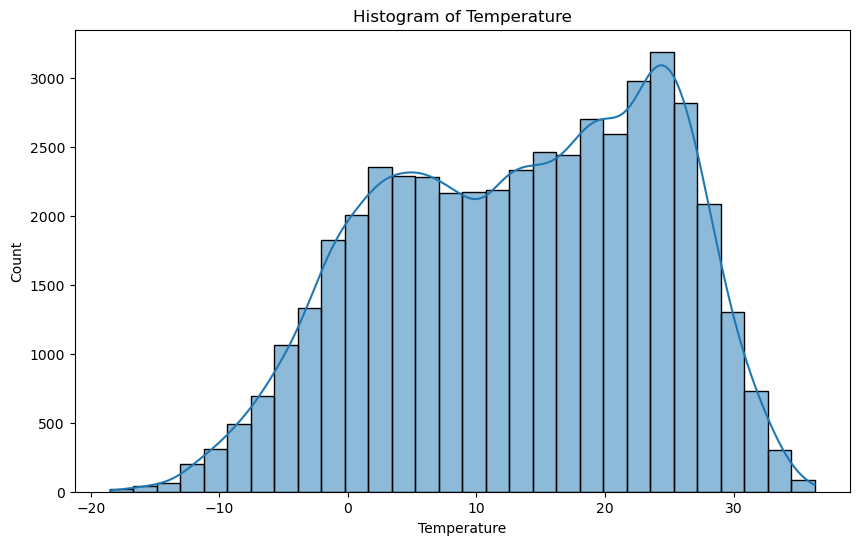

count    47511.000000
mean        13.396994
std         10.853668
min        -18.500000
25%          4.600000
50%         14.300000
75%         22.700000
max         36.300000
Name: Temperature, dtype: float64

In [15]:
# target 변수 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(df['Temperature'], bins=30, kde=True)
plt.title('Histogram of Temperature')
plt.show()

df['Temperature'].describe()

### Outlier

In [16]:
# IQR기반 이상치
def outlier_iqr(df, threshold=1.5):
    df = df.select_dtypes(include=['number']).copy()
    outlier_summary = []

    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        ratio = round(len(outliers) / len(df) * 100, 3)

        outlier_summary.append({
            'Column': col,
            'Outlier Count': len(outliers),
            'Outlier Ratio (%)': ratio})

    return pd.DataFrame(outlier_summary).sort_values(by='Outlier Ratio (%)', ascending=False).reset_index(drop=True)

In [17]:
outiler_df = outlier_iqr(df)
outiler_df = outiler_df[outiler_df['Outlier Ratio (%)'] > 0]
outiler_df

,Column,Outlier Count,Outlier Ratio (%)
0,PastWeatherCode,11826,24.891
1,CurrentWeatherCode,11028,23.211
2,PrecipitationData,6538,13.761
3,Visibility,5381,11.326
4,HourlyRainfall,5337,11.233
5,GustDirection,2731,5.748
6,GustSpeed,2731,5.748
7,GustTime,2731,5.748
8,LowestCloudHeight,2325,4.894
9,TotalSnowDepth,2066,4.348


In [18]:
# 도메인 기반 컬럼 제외
outiler_cols = outiler_df['Column'].tolist()
remove_cols = ['PastWeatherCode', 'ObservationType', 'PrecipitationData', 'CurrentWeatherCode', 'GustTime']
outlier_cols = [col for col in outiler_cols if col not in remove_cols]

outlier_iqr(df[outlier_cols]) # 재확인

,Column,Outlier Count,Outlier Ratio (%)
0,Visibility,5381,11.326
1,HourlyRainfall,5337,11.233
2,GustDirection,2731,5.748
3,GustSpeed,2731,5.748
4,LowestCloudHeight,2325,4.894
5,TotalSnowDepth,2066,4.348
6,DailyRainfall,1980,4.167
7,CumulativeRainfall,1980,4.167
8,WindSpeed,925,1.947
9,DailySnowDepth,800,1.684


In [19]:
df[outlier_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Visibility,47511.0,1842.691545,870.747473,23.0,1317.0,2000.0,2000.0,5000.0
HourlyRainfall,47511.0,-7.824769,3.519385,-9.0,-9.0,-9.0,-9.0,64.7
GustDirection,47511.0,-7.247943,7.410340,-9.0,-9.0,-9.0,-9.0,36.0
GustSpeed,47511.0,-7.824841,4.777227,-9.0,-9.0,-9.0,-9.0,24.0
LowestCloudHeight,47511.0,3.585759,15.676464,-9.0,-9.0,3.0,10.0,77.0
TotalSnowDepth,47511.0,-8.510701,2.393588,-9.0,-9.0,-9.0,-9.0,28.6
DailyRainfall,47511.0,-4.316615,11.033616,-9.0,-9.0,-9.0,0.0,176.2
CumulativeRainfall,47511.0,-4.316615,11.033616,-9.0,-9.0,-9.0,0.0,176.2
WindSpeed,47511.0,2.334573,1.189225,-9.0,1.5,2.2,3.0,8.8
DailySnowDepth,47511.0,-8.811873,1.489008,-9.0,-9.0,-9.0,-9.0,19.3


In [20]:
# 음수값 확인
negative_cols = df.select_dtypes(include=['number']).columns[df.select_dtypes(include=['number']).lt(0).any()]
negative_cols

Index(['WindDirection', 'WindSpeed', 'GustDirection', 'GustSpeed', 'GustTime',
       'LocalPressure', 'SeaLevelPressure', 'PressureTrend', 'PressureChange',
       'Temperature', 'DewPointTemperature', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'CurrentWeatherCode',
       'PastWeatherCode', 'TotalCloudCover', 'MidLowCloudCover',
       'LowestCloudHeight', 'UpperCloudType', 'MidCloudType', 'LowCloudType',
       'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'PrecipitationData', 'ObservationType'],
      dtype='object')

In [21]:
# hist_plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))

    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

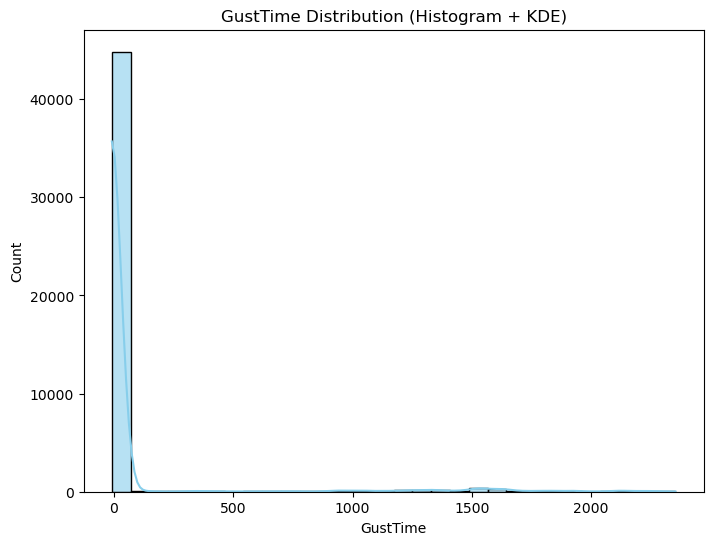

,GustTime
count,47511.000000
mean,68.349624
std,339.979739
min,-9.000000
25%,-9.000000
50%,-9.000000
75%,-9.000000
max,2354.000000


In [22]:
hist_plot(df, 'GustTime')
df[['GustTime']].describe()

In [23]:
impossible_minus_col = [
    'GustSpeed',           # 돌풍 속도: 속도이므로 음수 불가 (0은 바람 없음)
    'HourlyRainfall',      # 시간 강수량: 비의 양이므로 음수 불가 (0은 비 안 옴)
    'DailyRainfall',       # 일 강수량: 비의 양이므로 음수 불가
    'CumulativeRainfall',  # 누적 강수량: 비의 양이므로 음수 불가
    'RainfallIntensity',   # 강수 강도: 강수 세기이므로 음수 불가 (0은 비 안 옴)
    'SnowDepth3Hr',        # 3시간 적설: 눈의 깊이이므로 음수 불가 (0은 눈 안 쌓임)
    'DailySnowDepth',      # 일 적설: 눈의 깊이이므로 음수 불가
    'TotalSnowDepth',      # 총 적설: 눈의 깊이이므로 음수 불가
    'LowestCloudHeight',   # 최저 운고: 고도이므로 음수 불가 (0은 지표면 안개 등)
    'SunshineDuration',    # 일조 시간: 시간 값이므로 음수 불가 (0은 햇빛 없음)
    'SolarRadiation',      # 일사량: 에너지 양이므로 음수 불가 (0은 일사 없음)
    'WaveHeight',          # 파고: 파도의 높이이므로 음수 불가 (0은 파도 없음)
    'MaxWindForce'         # 최대 풍력: 풍력 값이므로 음수 불가
]

for col in impossible_minus_col:
    df[col] = df[col].apply(lambda x: 0 if x < 0 else x)

df[impossible_minus_col].describe().T

,count,mean,std,min,25%,50%,75%,max
GustSpeed,47511.0,0.657827,2.696842,0.0,0.0,0.00,0.00,24.00
HourlyRainfall,47511.0,0.164244,1.297983,0.0,0.0,0.00,0.00,64.70
DailyRainfall,47511.0,1.998407,8.918752,0.0,0.0,0.00,0.00,176.20
CumulativeRainfall,47511.0,1.998407,8.918752,0.0,0.0,0.00,0.00,176.20
RainfallIntensity,47511.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
SnowDepth3Hr,47511.0,0.004172,0.116027,0.0,0.0,0.00,0.00,9.80
DailySnowDepth,47511.0,0.036583,0.478294,0.0,0.0,0.00,0.00,19.30
TotalSnowDepth,47511.0,0.097937,0.820883,0.0,0.0,0.00,0.00,28.60
LowestCloudHeight,47511.0,7.879565,12.564853,0.0,0.0,3.00,10.00,77.00
SunshineDuration,47511.0,0.259361,0.403520,0.0,0.0,0.00,0.60,1.00


In [24]:
check_outiler = outlier_iqr(df)
check_outiler = check_outiler[check_outiler['Outlier Ratio (%)'] > 0]

outiler_cols = check_outiler['Column'].tolist()
remove_cols = ['PastWeatherCode', 'ObservationType', 'PrecipitationData', 'CurrentWeatherCode', 'GustTime']
outlier_cols = [col for col in outiler_cols if col not in remove_cols]

outlier_iqr(df[outlier_cols]) # 재확인

,Column,Outlier Count,Outlier Ratio (%)
0,CumulativeRainfall,9670,20.353
1,DailyRainfall,9670,20.353
2,Visibility,5381,11.326
3,LowestCloudHeight,4346,9.147
4,SolarRadiation,3460,7.283
5,HourlyRainfall,3008,6.331
6,GustDirection,2731,5.748
7,GustSpeed,2731,5.748
8,TotalSnowDepth,2046,4.306
9,WindSpeed,925,1.947


## Feature Engineering

- Derived Variable
- Spearman Test
- Kruskal-Wallis Test
- Encoding

### Spearman Test

In [25]:
def spearman_test(df, target_col):
    df_numeric = df.select_dtypes(include=['number'])
    features = []
    correlations = []
    p_values = []

    for col in df_numeric.columns:
        if col != target_col:
            corr, p = spearmanr(df_numeric[target_col], df_numeric[col])
            features.append(col)
            correlations.append(corr)
            p_values.append(p)

    corr_df = pd.DataFrame({
        'Feature': features,
        'Correlation': correlations,
        'P-value': p_values}).sort_values(by='Correlation', ascending=False).reset_index(drop=True)

    return corr_df

# heat_map
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])

        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

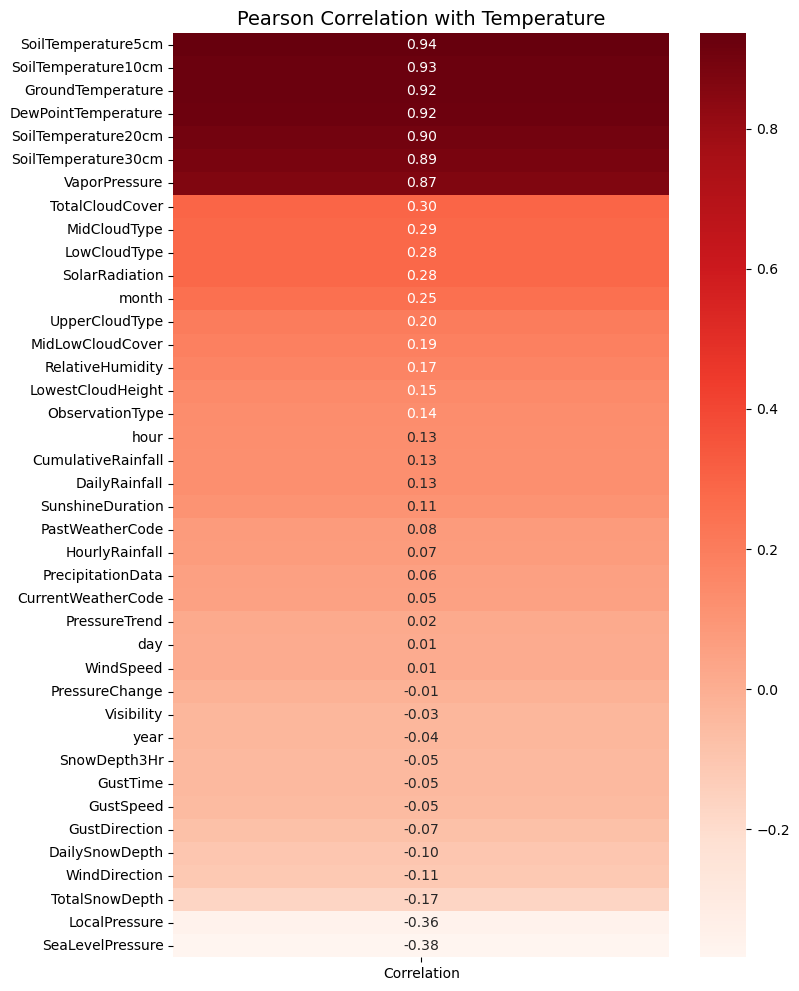

유의미하지 않은 변수의 수: 1
유의미한 변수의 수: 39


,Feature,Correlation,P-value
0,Visibility,0.007967,0.082482


In [26]:
heat_map(df, target_col='Temperature', figsize=(8, 12))
df_spearman = spearman_test(df, 'Temperature')

p_value_05 = df_spearman[df_spearman['P-value'] >= 0.05].reset_index(drop=True)
p_value_over_05 = df_spearman[df_spearman['P-value'] < 0.05].reset_index(drop=True)

print(f'유의미하지 않은 변수의 수: {len(p_value_05)}')
print(f'유의미한 변수의 수: {len(p_value_over_05)}')

p_value_05

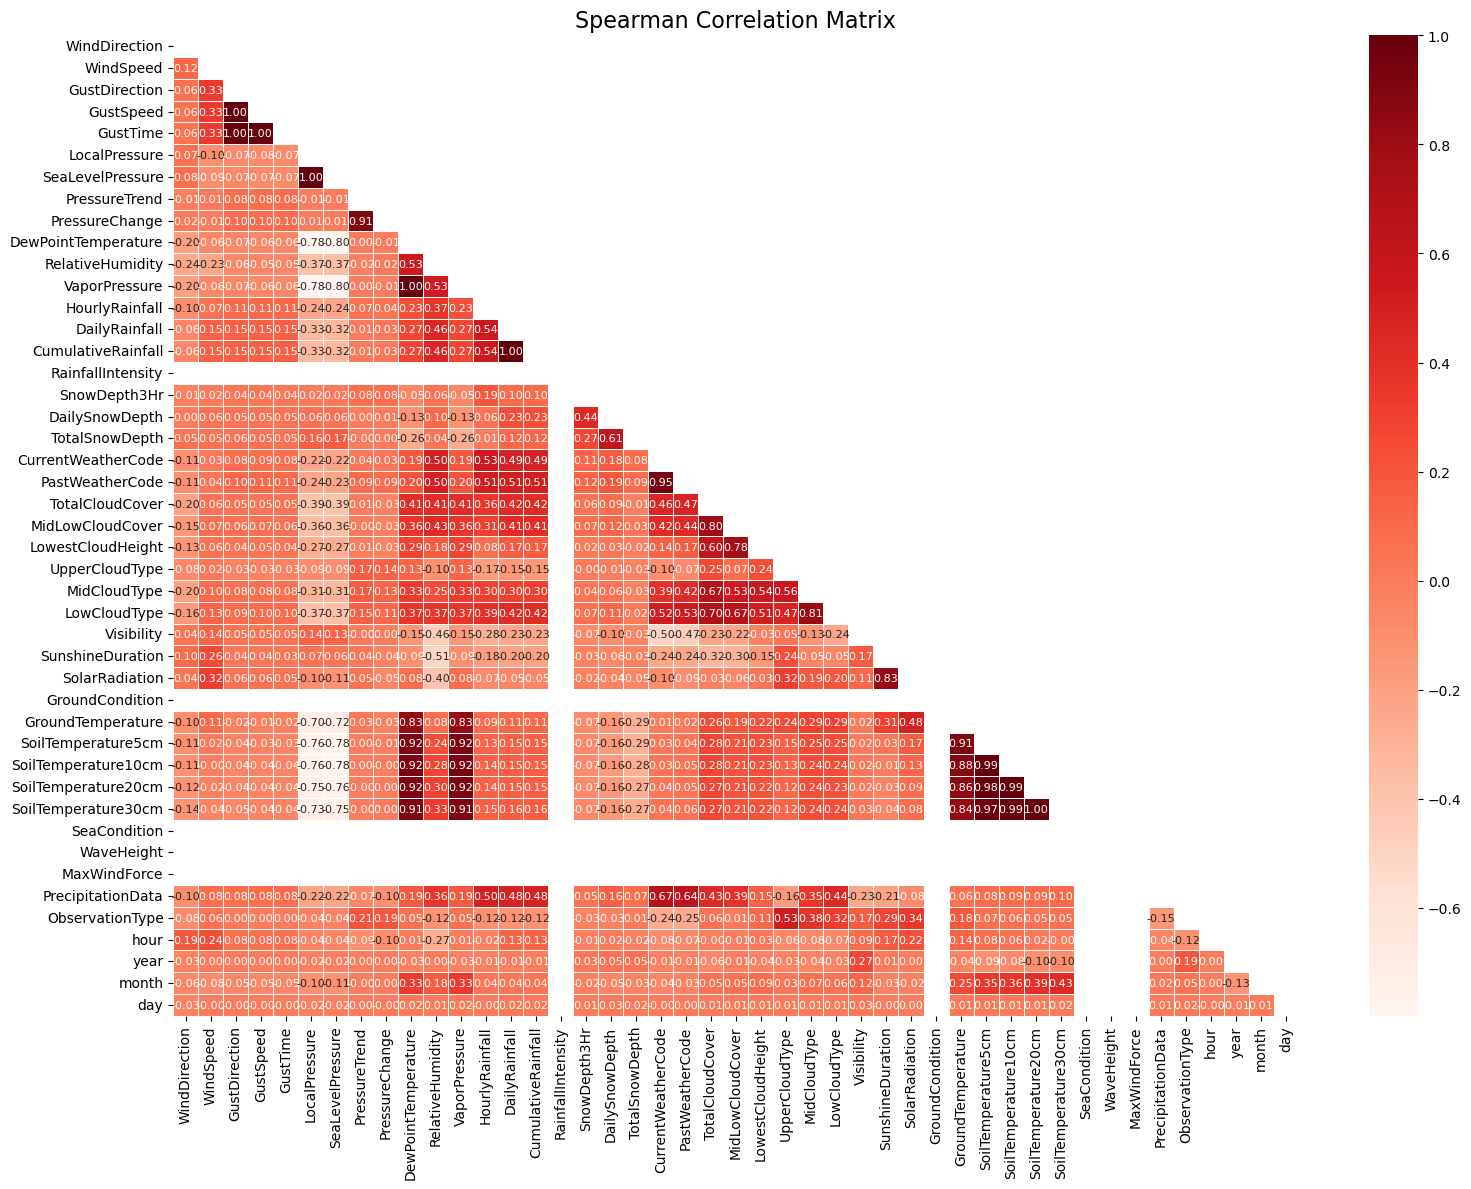

In [27]:
corr = df.select_dtypes(include=['number']).drop(columns=['Temperature']).corr(method='spearman')

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Reds', linewidths=0.5, mask=np.triu(corr), annot_kws={'size': 8})
plt.title("Spearman Correlation Matrix", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [28]:
def remove_high_corr_target(df, target_col, threshold=0.95, method='spearman'):
    feats = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    corr_feats = df[feats].corr(method=method).abs()
    corr_target = df[feats].corrwith(df[target_col], method=method).abs()

    to_drop = set()
    for i, f1 in enumerate(feats):
        for f2 in feats[i+1:]:
            # 0.95 초과인 경우
            if corr_feats.loc[f1, f2] > threshold:
                if corr_target[f1] >= corr_target[f2]:
                    to_drop.add(f2)
                else:
                    to_drop.add(f1)
    return list(to_drop)

In [29]:
corr_drop_cols = remove_high_corr_target(df, target_col='Temperature', threshold=0.95, method='spearman')
print("서로 상관계수가 0.95 초과인 피처 수:", len(corr_drop_cols))
print("상관계수 0.95 초과인 피처:", corr_drop_cols)

서로 상관계수가 0.95 초과인 피처 수: 8
상관계수 0.95 초과인 피처: ['SoilTemperature30cm', 'GustTime', 'DewPointTemperature', 'CumulativeRainfall', 'SoilTemperature10cm', 'SoilTemperature20cm', 'GustSpeed', 'LocalPressure']


In [30]:
# 유의미하지 않은 변수 제거
p_value_05_cols = p_value_05['Feature'].tolist()
drop_cols = p_value_05_cols + ['GustTime']

df = df.drop(columns=drop_cols)
df

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
0,2020-01-01 00:00:00,108,0,0.0,-9,0.0,1022.6,1033.8,7,-1.4,...,3.2,-9,0,0,4,1,0,2020,1,1
1,2020-01-01 01:00:00,108,5,1.7,-9,0.0,1021.8,1033.0,-9,-9.0,...,3.2,-9,0,0,4,1,1,2020,1,1
2,2020-01-01 02:00:00,108,0,0.1,-9,0.0,1021.6,1032.8,-9,-9.0,...,3.1,-9,0,0,4,1,2,2020,1,1
3,2020-01-01 03:00:00,108,0,0.0,-9,0.0,1021.5,1032.7,7,-1.1,...,3.1,-9,0,0,4,1,3,2020,1,1
4,2020-01-01 04:00:00,108,0,0.0,-9,0.0,1021.6,1032.8,-9,-9.0,...,3.0,-9,0,0,4,1,4,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47506,2025-06-03 21:00:00,108,25,2.3,23,11.0,990.5,1000.4,2,2.5,...,17.5,-9,0,0,3,2,21,2025,6,3
47507,2025-06-03 22:00:00,108,25,1.9,-9,0.0,991.2,1001.1,-9,-9.0,...,17.7,-9,0,0,3,-9,22,2025,6,3
47508,2025-06-03 23:00:00,108,27,2.3,-9,0.0,991.3,1001.3,-9,-9.0,...,20.8,-9,0,0,3,-9,23,2025,6,3
47509,2025-06-04 23:00:00,108,25,2.6,-9,0.0,998.1,1008.1,-9,-9.0,...,18.2,-9,0,0,3,-9,23,2025,6,4


### Kruskal-Wallis Test

In [31]:
def kruskal_test(df, target_col, min_group_size=5):
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    results = []

    for col in cat_cols:
        grouped = df.groupby(col)[target_col]
        valid_groups = [grp.values for _, grp in grouped if grp.size >= min_group_size]
        if len(valid_groups) >= 2:
            stat, p = kruskal(*valid_groups)
            results.append({'feature': col, 'H-statistic': stat, 'p-value': p})

    return pd.DataFrame(results).sort_values('p-value').reset_index(drop=True)

In [32]:
kruskal_df = kruskal_test(df, 'Temperature')
kruskal_df[kruskal_df['p-value'] < 0.05]

,feature,H-statistic,p-value
0,WeatherCode,3462.961845,0.0
1,CloudType,6166.536153,0.0


### Derived Variable

In [ ]:
def add_feature(df):
        # season
        df['season'] = df['month'].apply(lambda x:
            'Spring' if 3 <= x <= 5 else
            'Summer' if 6 <= x <= 8 else
            'Fall' if 9 <= x <= 11 else 'Winter')

        # time_segment
        df['time_segment'] = df['hour'].apply(lambda x:
            'Dawn' if 0 <= x < 6 else
            'Morning' if 6 <= x < 12 else
            'Afternoon' if 12 <= x < 18 else
            'Evening' if 18 <= x < 22 else
            'Night')

        # 전날 같은 시각 온도 변화량
        df['prev_day_temp_diff'] = df['Temperature'].diff(24)
        df['prev_day_temp_diff'] = df['prev_day_temp_diff'].fillna(method='bfill')  # 0보다 자연스러움

        # 태양복사량 × 시각 (일사 영향)
        df['temp_solar_effect'] = df['SolarRadiation'] * df['hour'].apply(lambda h: np.sin((np.pi / 24) * h))

        # 지온 - 지표온도 차이
        df['temp_soil_gap'] = df['SoilTemperature5cm'] - df['GroundTemperature']

        # 증기압 대비 습도 비율
        df['vapor_humidity_ratio'] = df['VaporPressure'] / (df['RelativeHumidity'] + 1e-3)

        # 해면기압 - 지역기압 차이
        df['pressure_diff'] = df['SeaLevelPressure'] - df['LocalPressure']

        # Day (0=Monday ~ 6=Sunday)
        df['day_of_week'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.dayofweek

        # Hour (0-23)
        max_hour = 23
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / (max_hour + 1))
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / (max_hour + 1))

        # Month (1-12)
        max_month = 12
        df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / max_month)
        df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / max_month)

        # Day (1-31)
        max_day = 31
        df['day_sin'] = np.sin(2 * np.pi * (df['day'] - 1) / max_day)
        df['day_cos'] = np.cos(2 * np.pi * (df['day'] - 1) / max_day)

        # Day-Week
        df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        return df

df = add_feature(df)
df.head()

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,2020-01-01 00:00:00,108,0,0.0,-9,0.0,1022.6,1033.8,7,-1.4,...,11.2,2,0.000000,1.000000,0.0,1.0,0.0,1.0,0.974928,-0.222521
1,2020-01-01 01:00:00,108,5,1.7,-9,0.0,1021.8,1033.0,-9,-9.0,...,11.2,2,0.258819,0.965926,0.0,1.0,0.0,1.0,0.974928,-0.222521
2,2020-01-01 02:00:00,108,0,0.1,-9,0.0,1021.6,1032.8,-9,-9.0,...,11.2,2,0.500000,0.866025,0.0,1.0,0.0,1.0,0.974928,-0.222521
3,2020-01-01 03:00:00,108,0,0.0,-9,0.0,1021.5,1032.7,7,-1.1,...,11.2,2,0.707107,0.707107,0.0,1.0,0.0,1.0,0.974928,-0.222521
4,2020-01-01 04:00:00,108,0,0.0,-9,0.0,1021.6,1032.8,-9,-9.0,...,11.2,2,0.866025,0.500000,0.0,1.0,0.0,1.0,0.974928,-0.222521


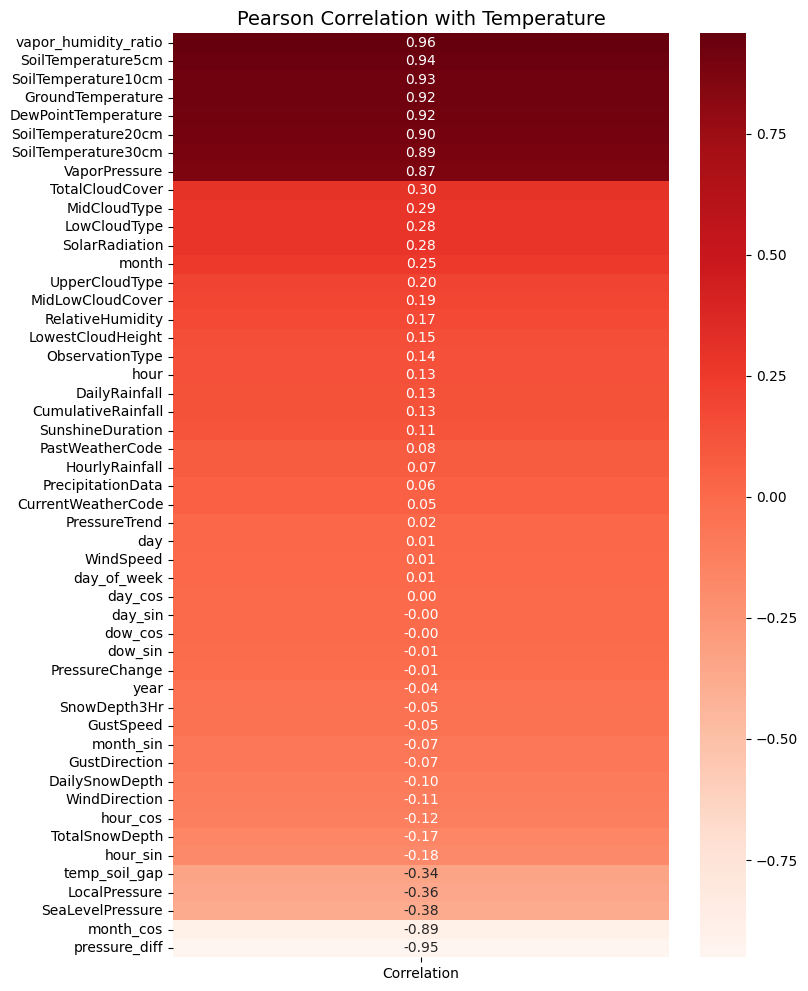

유의미하지 않은 변수의 수: 6
유의미한 변수의 수: 44


,Feature,Correlation,P-value
0,day_of_week,0.007177,0.117712
1,month_sin,0.005910,0.197678
2,day_cos,0.000742,0.871521
3,day_sin,-0.003672,0.423453
4,dow_cos,-0.006821,0.137083
5,dow_sin,-0.008987,0.050114


In [36]:
heat_map(df, target_col='Temperature', figsize=(8, 12))
df_spearman = spearman_test(df, 'Temperature')

p_value_05 = df_spearman[df_spearman['P-value'] >= 0.05].reset_index(drop=True)
p_value_over_05 = df_spearman[df_spearman['P-value'] < 0.05].reset_index(drop=True)

print(f'유의미하지 않은 변수의 수: {len(p_value_05)}')
print(f'유의미한 변수의 수: {len(p_value_over_05)}')

p_value_05

In [37]:
df.columns

Index(['ObservationTime', 'StationID', 'WindDirection', 'WindSpeed',
       'GustDirection', 'GustSpeed', 'LocalPressure', 'SeaLevelPressure',
       'PressureTrend', 'PressureChange', 'Temperature', 'DewPointTemperature',
       'RelativeHumidity', 'VaporPressure', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'CurrentWeatherCode',
       'PastWeatherCode', 'WeatherCode', 'TotalCloudCover', 'MidLowCloudCover',
       'LowestCloudHeight', 'CloudType', 'UpperCloudType', 'MidCloudType',
       'LowCloudType', 'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'PrecipitationData', 'ObservationType',
       'hour', 'year', 'month', 'day', 'season', 'time_segment',
       'temp_soil_gap', 'vapor_humidity_ratio', 

In [38]:
# 날씨 코드 'WeatherCode', 지점번호 'StationID', 관측시간 'ObservationTime' 제거
df = df.drop(columns=['WeatherCode', 'StationID', 'ObservationTime', 'CurrentWeatherCode', 'PastWeatherCode'])

# 컬럼 순서 변경
df = df[['year', 'month', 'day', 'hour', 'Temperature'] + [c for c in df if c not in ['year', 'month', 'day', 'hour', 'Temperature']]]
df

,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,2020,1,1,0,-6.5,0,0.0,-9,0.0,1022.6,...,11.2,2,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.974928,-0.222521
1,2020,1,1,1,-5.9,5,1.7,-9,0.0,1021.8,...,11.2,2,0.258819,0.965926,0.0,1.000000,0.000000,1.000000,0.974928,-0.222521
2,2020,1,1,2,-5.7,0,0.1,-9,0.0,1021.6,...,11.2,2,0.500000,0.866025,0.0,1.000000,0.000000,1.000000,0.974928,-0.222521
3,2020,1,1,3,-5.6,0,0.0,-9,0.0,1021.5,...,11.2,2,0.707107,0.707107,0.0,1.000000,0.000000,1.000000,0.974928,-0.222521
4,2020,1,1,4,-5.4,0,0.0,-9,0.0,1021.6,...,11.2,2,0.866025,0.500000,0.0,1.000000,0.000000,1.000000,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47506,2025,6,3,21,19.2,25,2.3,23,11.0,990.5,...,9.9,1,-0.707107,0.707107,0.5,-0.866025,0.394356,0.918958,0.781831,0.623490
47507,2025,6,3,22,18.3,25,1.9,-9,0.0,991.2,...,9.9,1,-0.500000,0.866025,0.5,-0.866025,0.394356,0.918958,0.781831,0.623490
47508,2025,6,3,23,17.5,27,2.3,-9,0.0,991.3,...,10.0,1,-0.258819,0.965926,0.5,-0.866025,0.394356,0.918958,0.781831,0.623490
47509,2025,6,4,23,19.2,25,2.6,-9,0.0,998.1,...,10.0,2,-0.258819,0.965926,0.5,-0.866025,0.571268,0.820763,0.974928,-0.222521


### Split Data

In [39]:
HORIZON = 168  # 예측하려는 미래 7일/일주일 (168시간)
SEQ_LEN = 336  # 입력 시퀀스: 과거 14일

df = df.sort_values(by=['year', 'month', 'day', 'hour']).reset_index(drop=True)
val_total_len = SEQ_LEN + HORIZON
val_df = df.iloc[-val_total_len:].copy()
train_df = df.iloc[:-val_total_len].copy()
latest_input = df.iloc[-SEQ_LEN:].copy()

print(f"train_df: {train_df.shape}")
print(f"val_df: {val_df.shape}")
print(f"latest_input: {latest_input.shape}")
train_df.head()

train_df: (47007, 57)
val_df: (504, 57)
latest_input: (336, 57)


,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,2020,1,1,0,-6.5,0,0.0,-9,0.0,1022.6,...,11.2,2,0.000000,1.000000,0.0,1.0,0.0,1.0,0.974928,-0.222521
1,2020,1,1,1,-5.9,5,1.7,-9,0.0,1021.8,...,11.2,2,0.258819,0.965926,0.0,1.0,0.0,1.0,0.974928,-0.222521
2,2020,1,1,2,-5.7,0,0.1,-9,0.0,1021.6,...,11.2,2,0.500000,0.866025,0.0,1.0,0.0,1.0,0.974928,-0.222521
3,2020,1,1,3,-5.6,0,0.0,-9,0.0,1021.5,...,11.2,2,0.707107,0.707107,0.0,1.0,0.0,1.0,0.974928,-0.222521
4,2020,1,1,4,-5.4,0,0.0,-9,0.0,1021.6,...,11.2,2,0.866025,0.500000,0.0,1.0,0.0,1.0,0.974928,-0.222521


### Scaler

In [40]:
train = train_df.copy()
val = val_df.copy()
latest = latest_input.copy()

# 스케일링 제외 컬럼 정의
exclude_cols = ['Temperature', 'year', 'month', 'day', 'hour',
                'month_sin', 'month_cos', 'day_sin', 'day_cos',
                'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'day_of_week']

# 수치형 컬럼 중 제외되지 않은 것만 선택
num_cols = [col for col in train.select_dtypes(include=['number']).columns if col not in exclude_cols]

# 스케일러 정의 및 적용
scaler = RobustScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
val[num_cols] = scaler.transform(val[num_cols])
latest[num_cols] = scaler.transform(latest[num_cols])

# 확인
latest.head()

,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
47175,2025,5,21,2,23.7,0.10,-0.133333,0.0,0.0,-0.578125,...,-0.444444,2,0.500000,8.660254e-01,0.866025,-0.5,-0.790776,-0.612106,0.974928,-0.222521
47176,2025,5,21,3,23.6,-0.15,-0.800000,0.0,0.0,-0.625000,...,-0.444444,2,0.707107,7.071068e-01,0.866025,-0.5,-0.790776,-0.612106,0.974928,-0.222521
47177,2025,5,21,4,23.4,0.55,-1.133333,0.0,0.0,-0.648438,...,-0.444444,2,0.866025,5.000000e-01,0.866025,-0.5,-0.790776,-0.612106,0.974928,-0.222521
47178,2025,5,21,5,23.1,0.20,-0.066667,0.0,0.0,-0.617188,...,-0.444444,2,0.965926,2.588190e-01,0.866025,-0.5,-0.790776,-0.612106,0.974928,-0.222521
47179,2025,5,21,6,23.0,0.10,-0.400000,0.0,0.0,-0.632813,...,-0.444444,2,1.000000,6.123234e-17,0.866025,-0.5,-0.790776,-0.612106,0.974928,-0.222521


### Encoding

In [41]:
str_df, num_df = check_dtype(df ,return_data=True)

for col in str_df.columns:
    print(f"{col}의 유니크 수: {str_df[col].nunique()}")

Object Data Type: 3
Number Data Type: 54
CloudType의 유니크 수: 60
season의 유니크 수: 4
time_segment의 유니크 수: 5


In [42]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from packaging import version
import sklearn

# 인코더 저장용
label_encoders = {}
onehot_encoders = {}

# 문자열(범주형) 컬럼 추출
str_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
label_cols = []
onehot_cols = []

# 라벨 vs 원핫 기준 분리
for col in str_cols:
    if train[col].nunique() <= 10:
        onehot_cols.append(col)
    else:
        label_cols.append(col)

# Label Encoding
for col in label_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = val[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    latest[col] = latest[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le

# One-Hot Encoding
for col in onehot_cols:
    if version.parse(sklearn.__version__) >= version.parse("1.2.0"):
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    else:
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # 학습
    ohe.fit(train[[col]])
    ohe_cols = ohe.get_feature_names_out([col])

    # train
    train_ohe = pd.DataFrame(ohe.transform(train[[col]]), columns=ohe_cols, index=train.index)
    train.drop(columns=[col], inplace=True)
    train = pd.concat([train, train_ohe], axis=1)

    # val
    val_ohe = pd.DataFrame(ohe.transform(val[[col]]), columns=ohe_cols, index=val.index)
    val.drop(columns=[col], inplace=True)
    val = pd.concat([val, val_ohe], axis=1)

    # latest
    latest_ohe = pd.DataFrame(ohe.transform(latest[[col]]), columns=ohe_cols, index=latest.index)
    latest.drop(columns=[col], inplace=True)
    latest = pd.concat([latest, latest_ohe], axis=1)

    onehot_encoders[col] = ohe

# 시계열 보존
latest_time = latest[['year', 'month', 'day', 'hour']].copy()

# 불필요 날짜 컬럼 제거
drop_cols = ['year', 'month', 'day']
train.drop(columns=drop_cols, inplace=True)
val.drop(columns=drop_cols, inplace=True)
latest.drop(columns=drop_cols, inplace=True)

# 컬럼 순서 통일
val = val[train.columns]
latest = latest[train.columns]

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"latest: {latest.shape}")

train: (47007, 61)
val: (504, 61)
latest: (336, 61)


In [43]:
def check_column_order(X_train, X_val, X_train_name='X_train', X_val_name='X_val'):
    if X_train.columns.tolist() == X_val.columns.tolist():
        print(f"{X_train_name}과 {X_val_name}의 컬럼 및 순서가 모두 일치")
    else:
        print(f"{X_train_name}과 {X_val_name}의 컬럼 또는 순서 불일치")

        train_cols_set = set(X_train.columns)
        val_cols_set = set(X_val.columns)

        only_in_train = list(train_cols_set - val_cols_set)
        only_in_val = list(val_cols_set - train_cols_set)

        if only_in_train or only_in_val:
            print("컬럼 이름 불일치:")
            print(f"{X_train_name}에만 있는 컬럼:", only_in_train)
            print(f"{X_val_name}에만 있는 컬럼:", only_in_val)
        else:
            print("컬럼 이름은 동일하나 순서가 다름\n")

            for i, (col_train, col_val) in enumerate(zip(X_train.columns, X_val.columns)):
                if col_train != col_val:
                    print(f"{i}번째 컬럼 순서 불일치: {X_train_name} = {col_train}, {X_val_name} = {col_val}")

check_column_order(train, val, 'train', 'val')
check_column_order(train, latest, 'train', 'latest')

train과 val의 컬럼 및 순서가 모두 일치
train과 latest의 컬럼 및 순서가 모두 일치


In [44]:
# # 컬럼 순서 통일
# val = val[train.columns]
# latest_input = latest_input[train.columns]
# check_column_order(train, val, 'train', 'val') # 재확인
# check_column_order(train, latest_input, 'train', 'latest_input') # 재확인

## Models

In [45]:
# Dataset 클래스
class TempDataset(Dataset):
    def __init__(self, df, label_col, horizon, seq_len):
        self.seq_len = seq_len
        self.horizon = horizon
        self.X = df.drop(columns=[label_col]).values.astype(np.float32)
        self.y = df[label_col].values.astype(np.float32)
        self.input_len = len(self.X) - seq_len - horizon + 1

    def __len__(self):
        return self.input_len

    def __getitem__(self, idx):
        X_seq = self.X[idx: idx + self.seq_len]
        y_seq = self.y[idx + self.seq_len: idx + self.seq_len + self.horizon]
        return torch.tensor(X_seq), torch.tensor(y_seq)

# LSTM 모델 정의
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [B, seq_len, H]
        last_out = lstm_out[:, -1, :]  # [B, H]
        output = self.fc(last_out)     # [B, horizon]
        return output

# Trainer 클래스
class LSTMTrainer:
    def __init__(self, model, device, lr=0.001):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.train_losses = []
        self.val_losses = []

    def train(self, train_loader, val_loader, epochs=20, patience=5):
        best_val_loss = float('inf')
        best_model = None
        wait = 0

        for epoch in range(1, epochs + 1):
            self.model.train()
            train_loss = 0.0
            for X, y in train_loader:
                X, y = X.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                pred = self.model(X)
                loss = self.criterion(pred, y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)

            # Validation
            self.model.eval()
            val_loss = 0.0
            all_preds, all_labels = [], []
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv, yv = Xv.to(self.device), yv.to(self.device)
                    pred = self.model(Xv)
                    loss = self.criterion(pred, yv)
                    val_loss += loss.item()
                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(yv.cpu().numpy())
            val_loss /= len(val_loader)
            rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping triggered at epoch {epoch}.")
                    break

        # Best 모델 로드
        if best_model is not None:
            self.model.load_state_dict(best_model)


def predict(model, device, latest_seq, latest_time, horizon=168):
    model.eval()
    with torch.no_grad():
        inp = torch.tensor(latest_seq, dtype=torch.float32).unsqueeze(0).to(device)  # [1, seq_len, input_size]
        output = model(inp)  # [1, horizon]
        preds = output.cpu().numpy().flatten()

    # 예측 시점 생성
    last_row = latest_time.iloc[-1]
    last_time = datetime(
        year=int(last_row["year"]),
        month=int(last_row["month"]),
        day=int(last_row["day"]),
        hour=int(last_row["hour"])
    )
    future_times = [last_time + timedelta(hours=i + 1) for i in range(horizon)]

    df = pd.DataFrame({
        'year': [t.year for t in future_times],
        'month': [t.month for t in future_times],
        'day': [t.day for t in future_times],
        'hour': [t.hour for t in future_times],
        'day_of_week': [t.strftime('%A') for t in future_times],
        'pred_Temperature': np.round(preds, 1)
    })

    return df

In [46]:
# !pip install --upgrade --force-reinstall sympy

In [48]:
# 파라미터 정의
HORIZON = 168  # 예측할 시간 수 (7일)
SEQ_LEN = 336  # 입력 시계열 길이 (2주)
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.0007  # 학습률
DROPOUT = 0.4  # 드롭아웃
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더
train_loader = DataLoader(TempDataset(train, 'Temperature', HORIZON, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TempDataset(val, 'Temperature', HORIZON, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=False)

# 모델 초기화 및 학습
model = LSTM_Model(input_size=train.shape[1]-1, hidden_size=128, num_layers=2, output_size=HORIZON, dropout=DROPOUT)
trainer = LSTMTrainer(model, DEVICE, lr=LR)  # ← 여기서 input_size 제거
trainer.train(train_loader, val_loader, epochs=EPOCHS)

# 예측
latest_seq = latest.drop(columns=['Temperature']).values[-SEQ_LEN:].astype(np.float32)
pred_df = predict(trainer.model, DEVICE, latest_seq, latest_time, horizon=HORIZON)
pred_df

[Epoch 1] Train Loss: 47.5668 | Val Loss: 18.6046 | RMSE: 4.3133
[Epoch 2] Train Loss: 16.7607 | Val Loss: 14.0380 | RMSE: 3.7467
[Epoch 3] Train Loss: 10.2324 | Val Loss: 11.7772 | RMSE: 3.4318
[Epoch 4] Train Loss: 6.7727 | Val Loss: 14.9739 | RMSE: 3.8696
[Epoch 5] Train Loss: 4.8217 | Val Loss: 20.8641 | RMSE: 4.5677
[Epoch 6] Train Loss: 3.7970 | Val Loss: 15.0860 | RMSE: 3.8841
[Epoch 7] Train Loss: 3.2322 | Val Loss: 10.9297 | RMSE: 3.3060
[Epoch 8] Train Loss: 2.8050 | Val Loss: 15.3609 | RMSE: 3.9193
[Epoch 9] Train Loss: 2.5386 | Val Loss: 17.8593 | RMSE: 4.2260
[Epoch 10] Train Loss: 2.3027 | Val Loss: 9.8557 | RMSE: 3.1394
[Epoch 11] Train Loss: 2.1096 | Val Loss: 12.4061 | RMSE: 3.5222
[Epoch 12] Train Loss: 1.9326 | Val Loss: 9.2601 | RMSE: 3.0430
[Epoch 13] Train Loss: 1.8134 | Val Loss: 16.5887 | RMSE: 4.0729
[Epoch 14] Train Loss: 1.9938 | Val Loss: 4.4140 | RMSE: 2.1009
[Epoch 15] Train Loss: 1.5796 | Val Loss: 3.2761 | RMSE: 1.8100
[Epoch 16] Train Loss: 1.4946 | Val

,year,month,day,hour,day_of_week,pred_Temperature
0,2025,6,5,22,Thursday,18.900000
1,2025,6,5,23,Thursday,18.299999
2,2025,6,6,0,Friday,17.600000
3,2025,6,6,1,Friday,17.000000
4,2025,6,6,2,Friday,16.700001
...,...,...,...,...,...,...
163,2025,6,12,17,Thursday,23.700001
164,2025,6,12,18,Thursday,22.799999
165,2025,6,12,19,Thursday,22.200001
166,2025,6,12,20,Thursday,21.799999


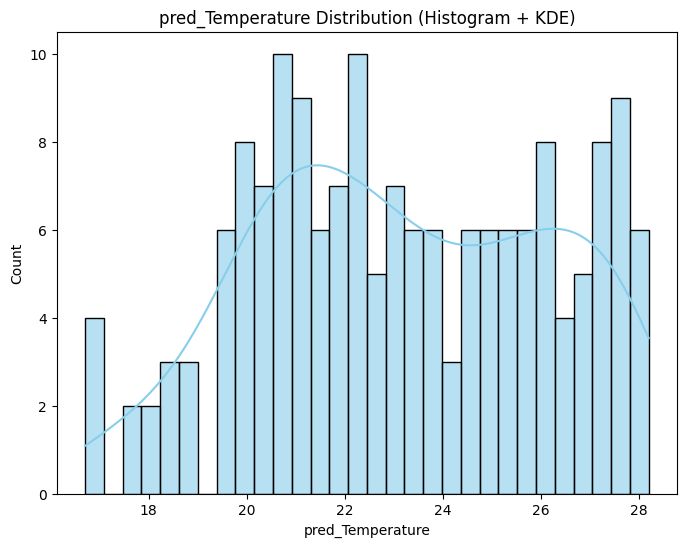

In [49]:
hist_plot(pred_df, 'pred_Temperature')

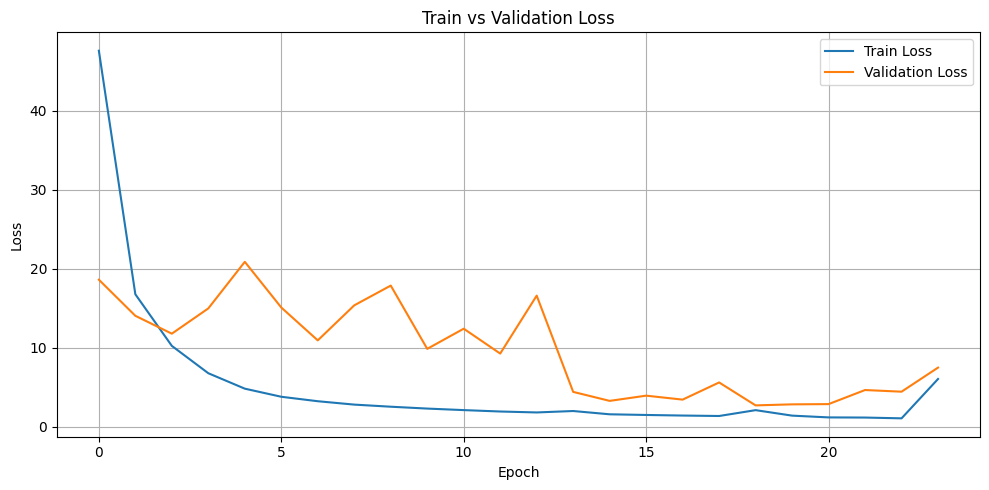

In [50]:
def plot_losses(trainer):
    plt.figure(figsize=(10, 5))
    plt.plot(trainer.train_losses, label='Train Loss')
    plt.plot(trainer.val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_losses(trainer)

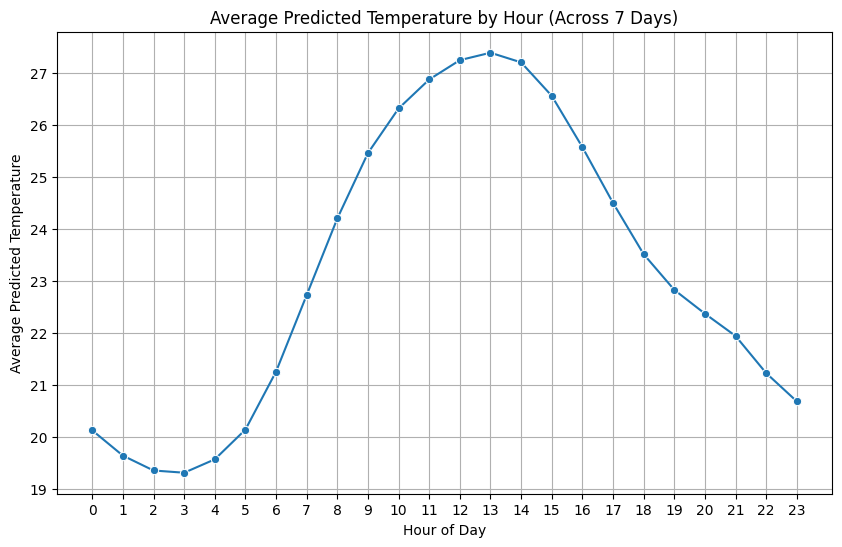

In [54]:
hourly_avg = pred_df.groupby('hour')['pred_Temperature'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_avg, x='hour', y='pred_Temperature', marker='o')
plt.title("Average Predicted Temperature by Hour (Across 7 Days)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Predicted Temperature")
plt.grid(True)
plt.xticks(range(0, 24))  # 0~23시
plt.show()

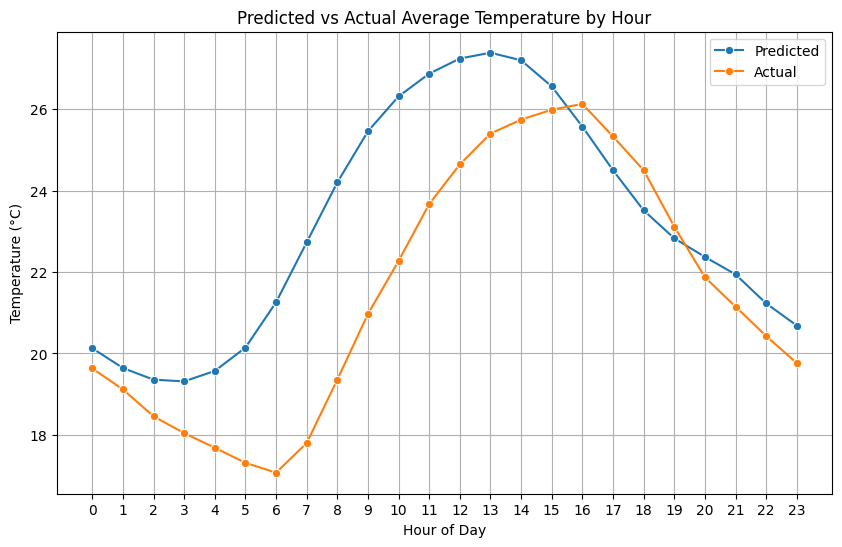

In [59]:
hourly_pred = pred_df.groupby('hour')['pred_Temperature'].mean().reset_index()
hourly_pred.rename(columns={'pred_Temperature': 'Predicted'}, inplace=True)

# 실제값: 마지막 7일치와 같은 row 수만큼 뽑은 후 시간대별 평균
n_pred_rows = len(pred_df)
latest_subset = latest.iloc[-n_pred_rows:]  # 마지막 예측 구간과 일치시키기
hourly_actual = latest_subset.groupby('hour')['Temperature'].mean().reset_index()
hourly_actual.rename(columns={'Temperature': 'Actual'}, inplace=True)

# 병합
comparison_df = pd.merge(hourly_pred, hourly_actual, on='hour')

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x='hour', y='Predicted', marker='o', label='Predicted')
sns.lineplot(data=comparison_df, x='hour', y='Actual', marker='o', label='Actual')
plt.title("Predicted vs Actual Average Temperature by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend()
plt.show()

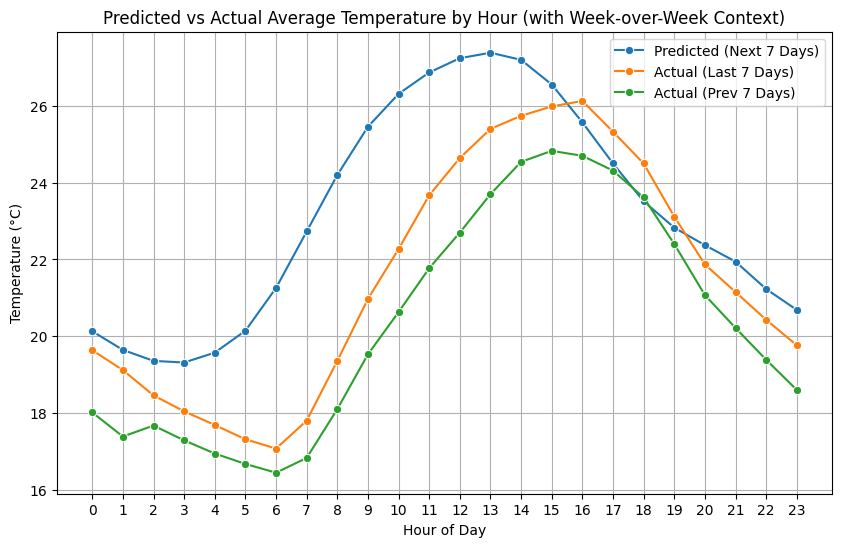

In [60]:
# 모델 예측 (향후 7일)
hourly_pred = pred_df.groupby('hour')['pred_Temperature'].mean().reset_index()
hourly_pred.rename(columns={'pred_Temperature': 'Predicted'}, inplace=True)

# 실제값에서 최근 14일 중 마지막 7일과 그 전 7일 분할
n_pred_rows = len(pred_df)  # 보통 168개 (7일 * 24시간)
latest_recent = latest.iloc[-n_pred_rows:]            # 최신 7일
latest_previous = latest.iloc[-2 * n_pred_rows:-n_pred_rows]  # 이전 7일

# 시간대별 평균 계산
hourly_actual_recent = latest_recent.groupby('hour')['Temperature'].mean().reset_index()
hourly_actual_recent.rename(columns={'Temperature': 'Actual_Recent'}, inplace=True)

hourly_actual_prev = latest_previous.groupby('hour')['Temperature'].mean().reset_index()
hourly_actual_prev.rename(columns={'Temperature': 'Actual_Prev'}, inplace=True)

# 병합
comparison_df = hourly_pred.merge(hourly_actual_recent, on='hour') \
                           .merge(hourly_actual_prev, on='hour')

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x='hour', y='Predicted', marker='o', label='Predicted (Next 7 Days)')
sns.lineplot(data=comparison_df, x='hour', y='Actual_Recent', marker='o', label='Actual (Last 7 Days)')
sns.lineplot(data=comparison_df, x='hour', y='Actual_Prev', marker='o', label='Actual (Prev 7 Days)')
plt.title("Predicted vs Actual Average Temperature by Hour (with Week-over-Week Context)")
plt.xlabel("Hour of Day")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend()
plt.show()

In [64]:
train

,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,dow_cos,season_Fall,season_Spring,season_Summer,season_Winter,time_segment_Afternoon,time_segment_Dawn,time_segment_Evening,time_segment_Morning,time_segment_Night
0,0,-6.5,-1.15,-1.466667,0.0,0.0,1.289063,1.296296,1.454545,0.926829,...,-0.222521,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,-5.9,-0.90,-0.333333,0.0,0.0,1.226562,1.237037,0.000000,0.000000,...,-0.222521,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,-5.7,-1.15,-1.400000,0.0,0.0,1.210938,1.222222,0.000000,0.000000,...,-0.222521,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,-5.6,-1.15,-1.466667,0.0,0.0,1.203125,1.214815,1.454545,0.963415,...,-0.222521,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4,-5.4,-1.15,-1.466667,0.0,0.0,1.210938,1.222222,0.000000,0.000000,...,-0.222521,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47002,21,21.1,0.00,0.600000,34.0,10.0,-0.117188,-0.133333,1.000000,1.231707,...,0.623490,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
47003,22,20.2,0.00,-0.666667,0.0,0.0,-0.085938,-0.096296,0.000000,0.000000,...,0.623490,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47004,23,18.9,-0.15,-0.666667,0.0,0.0,-0.117188,-0.125926,0.000000,0.000000,...,0.623490,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47005,0,17.7,0.65,-0.600000,0.0,0.0,-0.093750,-0.103704,0.818182,1.146341,...,-0.222521,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
